In [ ]:
import numpy as np
import pandas as pd

fps = ['./SW_OPER_MAGB_HR_1B_1349_20140219T020540_20140219T034014.pkl',
       './aux_SW_OPER_MAGB_HR_1B_1349_20140219T020540_20140219T034014.pkl',
       './IGRF_SW_OPER_MAGB_HR_1B_1349_20140219T020540_20140219T034014.pkl',
       './SW_EXPT_EFIB_TCT16_1349_20140219T020540_20140219T034014.pkl']
df_b = pd.read_pickle(fps[0])
df_b_aux = pd.read_pickle(fps[1])
df_b_IGRF = pd.read_pickle(fps[2])
df_e = pd.read_pickle(fps[3])

st = '20140219T023100'
et = '20140219T024100'
df_b_clip = df_b[['B_NEC', 'Longitude', 'Latitude', 'Radius','q_NEC_CRF']]
df_b_clip = df_b_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_aux_clip = df_b_aux[['QDLat', 'QDLon', 'MLT']]
df_b_aux_clip = df_b_aux_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_IGRF_clip = df_b_IGRF[['B_NEC_IGRF']]
df_b_IGRF_clip = df_b_IGRF_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_e_clip = df_e[['Longitude', 'Latitude', 'Radius', 'VsatE', 'VsatN', 'Ehy', 'Ehx']]
df_e_clip = df_e_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]

from pyaw import utils

In [3]:
ehx = df_e_clip['Ehx'].values

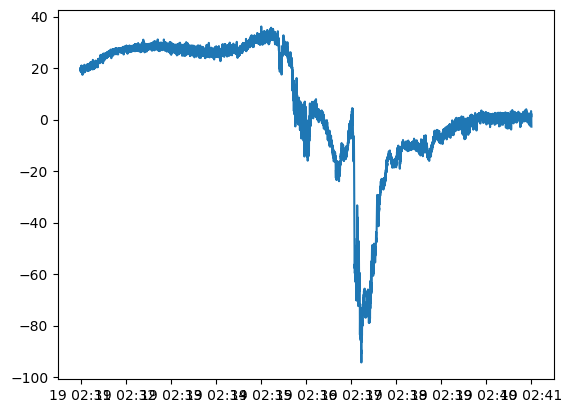

In [4]:
import matplotlib.pyplot as plt
plt.plot(df_e_clip.index.values, ehx)
plt.show()

In [5]:
np.all(np.equal(df_b_clip.index.values,df_b_IGRF_clip.index.values))

True

In [15]:
df_b_clip['q_NEC_CRF'].values

array([array([-0.00324003, -0.00285423, -0.98691967,  0.16115494]),
       array([-0.00323998, -0.00285434, -0.98692484,  0.16112328]),
       array([-0.00323992, -0.00285445, -0.98693003,  0.16109153]), ...,
       array([-0.00512859, -0.00150926, -0.99998361, -0.00204726]),
       array([-0.00512868, -0.00150909, -0.99998361, -0.00204835]),
       array([-0.00512877, -0.00150892, -0.99998361, -0.00204943])],
      dtype=object)

In [18]:
_, be, _ = utils.get_3arrs(df_b_clip['B_NEC'].values)

In [21]:
for i in df_b_clip['B_NEC'].values[:2]:
    print(i,type(i))

[ 1055.4257   433.8423 46419.2991] <class 'numpy.ndarray'>
[ 1055.7534   433.9479 46419.2873] <class 'numpy.ndarray'>


In [22]:
# Define quaternion multiplication
def quaternion_multiply(p, q):
    p1,p2,p3,p4 = p
    q1,q2,q3,q4 = q
    return np.array([
        p1*q4+p2*q3-p3*q2+p4*q1,
        -p1*q3+p2*q4+p3*q1+p4*q2,
        p1*q2-p2*q1+p3*q4+p4*q3,
        -p1*q1-p2*q2-p3*q3+p4*q4
    ])


# Rotate vector using quaternion
def rotate_vector_by_quaternion(vector, quaternion):
    vector_quat = np.array([*vector, 0])  # Convert vector to quaternion form
    quaternion_conj = np.array([-quaternion[0], -quaternion[1], -quaternion[2], quaternion[3]])
    rotated_quat = quaternion_multiply(
        quaternion_multiply(quaternion_conj, vector_quat),
        quaternion
    )
    return rotated_quat[:3]  # Return only the vector part

In [ ]:
b_sc = []
b_igrf_sc = []
for b_nec,b_nec_igrf,q_NEC_CRF in zip(df_b_clip['B_NEC'].values,df_b_IGRF_clip['B_NEC_IGRF'].values,df_b_clip['q_NEC_CRF'].values):
    q_CRF_NEC = np.array([-q_NEC_CRF[0],-q_NEC_CRF[1],-q_NEC_CRF[2],q_NEC_CRF[3]])
    b_sc.append(rotate_vector_by_quaternion(b_nec, q_CRF_NEC))
    b_igrf_sc.append(rotate_vector_by_quaternion(b_nec_igrf, q_CRF_NEC))
b_sc = np.array(b_sc)
b_igrf_sc = np.array(b_igrf_sc)

In [27]:
by1 = b_sc[:,1] - b_igrf_sc[:,1]

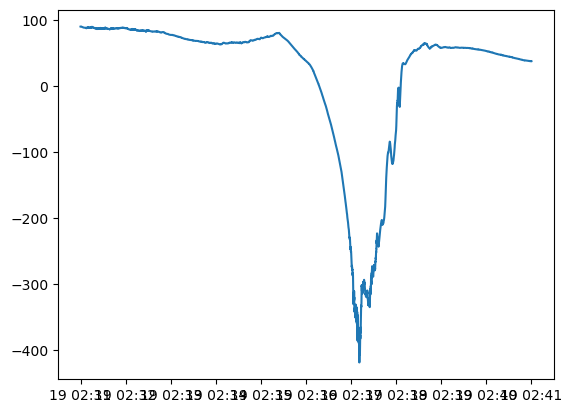

In [28]:
plt.plot(df_b_clip.index.values, by1)

In [29]:
datetimes_e = df_e_clip.index.values
datetimes_b = df_b_clip.index.values

by1 = utils.align_high2low(by1, datetimes_b, datetimes_e)

In [46]:

from scipy.signal import stft

fs = 16
window = 'hann'
stft_window_seconds = 4  # second
nperseg = int(stft_window_seconds * fs)  # 每个窗的采样点数
noverlap = nperseg // 2  # 50%重叠

# get stft
# freqs, ts, Zxx_e = stft(ehx, fs, window=window, nperseg=nperseg, noverlap=noverlap,
#                         scaling='spectrum',padded=False,boundary=None)
# _, _, Zxx_b = stft(by1, fs, window=window, nperseg=nperseg, noverlap=noverlap,
#                    scaling='spectrum',padded=False,boundary=None)

from scipy.signal import spectrogram
freqs, ts, Zxx_e = spectrogram(ehx, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')
_, _, Zxx_b = spectrogram(by1, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')

ts_dt64 = datetimes_e[0] + [np.timedelta64(int(_), 's') for _ in ts]

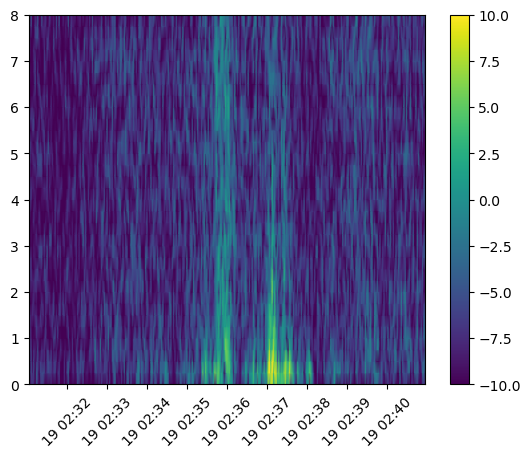

In [47]:

import matplotlib.pyplot as plt

Zxx_e_m = np.abs(Zxx_e)
plt.pcolormesh(ts_dt64, freqs, 10*np.log10(Zxx_e_m), shading='gouraud',vmin=-10,vmax=10)  # 可以用初始值也可以用log10
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

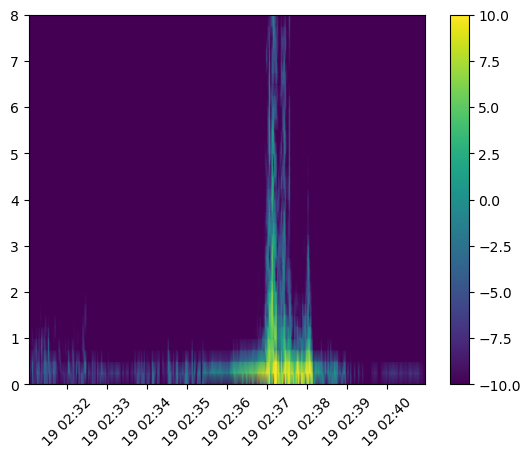

In [48]:

Zxx_b_m = np.abs(Zxx_b)
plt.pcolormesh(ts_dt64, freqs, 10*np.log10(Zxx_b_m), shading='gouraud',vmin=-10,vmax=10)
plt.colorbar()
plt.ylim([0, 8])
plt.xticks(rotation=45)
plt.show()

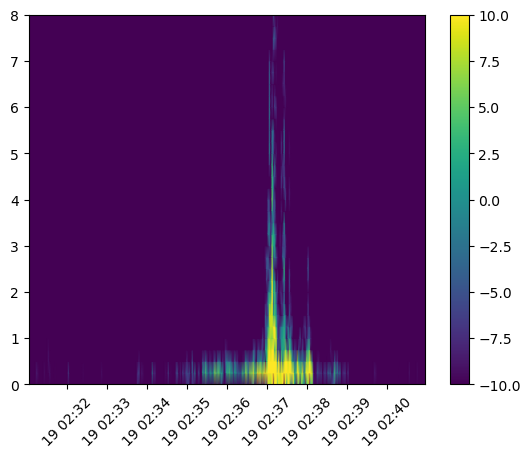

In [49]:

cross_e_b_spectral_density = Zxx_e * np.conj(Zxx_b)

cross_e_b_spectral_density_module = np.abs(cross_e_b_spectral_density)
plt.pcolormesh(ts_dt64, freqs, 10*np.log10(cross_e_b_spectral_density_module), shading='gouraud',vmin=-10,vmax=10)
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

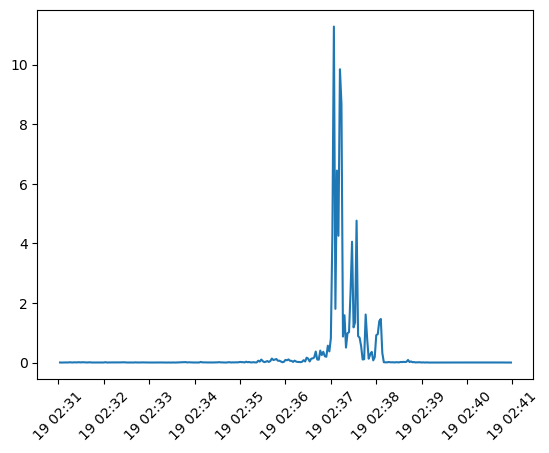

In [50]:
plt.figure()
plt.plot(ts_dt64, cross_e_b_spectral_density_module.mean(axis=0))
plt.xticks(rotation=45)
plt.show()


In [70]:

def split_array(data, step=11):  # todo:: step
    # Split the array
    result = [data[:, i:i + step] for i in range(0, data.shape[1] - step, step)]  # todo:: 更少的组成一部分；时间对应
    # Add the remaining columns to the last segment
    remainder = data[:, step * len(result):]
    if remainder.size > 0:
        if len(result) > 0:
            # Append remaining columns to the last split
            result[-1] = np.hstack((result[-1], remainder))
        else:
            # If there's no initial split, the remainder is the only result
            result.append(remainder)
    # # Convert result to a NumPy array (optional)
    # print(f"Number of resulting arrays: {len(result)}")
    # for idx, arr in enumerate(result):
    #     print(f"Shape of array {idx}: {arr.shape}")
    return result


In [71]:

cross_e_b_spectral_density_split = split_array(cross_e_b_spectral_density)  # ls
denominator1ls = split_array(np.abs(Zxx_e ** 2))
denominator2ls = split_array(np.abs(Zxx_b ** 2))

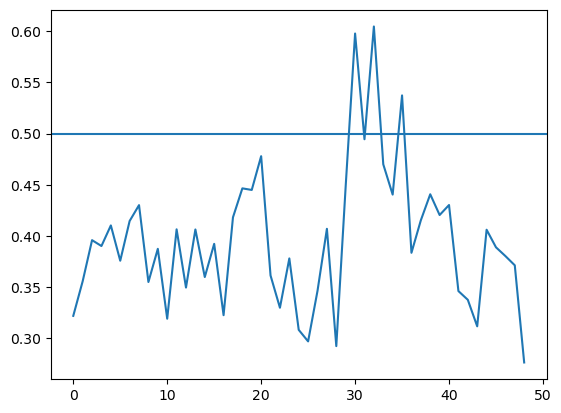

In [72]:

coherences_f = []
for i in range(len(cross_e_b_spectral_density_split)):
    nominator = cross_e_b_spectral_density_split[i].mean(axis=1)
    denominator = np.sqrt(denominator1ls[i].mean(axis=1)) * np.sqrt(denominator2ls[i].mean(axis=1))
    coherences_f.append(nominator / denominator)
    # denominator = sum(cross_e_b_spectral_density_module_split[i]) / len(cross_e_b_spectral_density_module_split[i])
    # nominator = np.sqrt(sum(nominator1ls[i]) / len(nominator1ls[i])) * np.sqrt(sum(nominator2ls[i]) / len(nominator2ls[i]))
    # coherences_spec.append(sum(np.abs(denominator / nominator)) / len(np.abs(denominator / nominator)))

coherences = []
for c_f in coherences_f:
    coherences.append(np.abs(c_f).mean())

plt.figure()
plt.plot(coherences)
plt.axhline(0.5)
plt.show()

denominator: [ 2.90973985e-03-9.57978857e-04j -3.02049260e-06+2.43788362e-04j
  9.19103672e-04-5.74269536e-04j -3.25594639e-03+3.96161199e-05j
 -2.23042959e-04+1.68900731e-03j -2.08834444e-04+1.72244561e-03j
  7.68696016e-04+3.72230582e-03j -6.20835988e-03+2.32702051e-03j
  6.06370145e-04-1.15835194e-03j  4.35010498e-04-8.90066591e-04j]
nominator: [0.01104178 0.00810883 0.00530997 0.01386719 0.009478   0.00925759
 0.01537872 0.02058462 0.01446367 0.00966946]
denominator/nominator [ 0.26352079-0.08675942j -0.00037249+0.03006456j  0.17309013-0.10814927j
 -0.23479491+0.00285682j -0.0235327 +0.17820294j -0.0225582 +0.18605774j
  0.04998439+0.24204263j -0.30160181+0.11304654j  0.04192367-0.08008699j
  0.0449881 -0.09204928j]
coherency: 0.18756770927023234
----------------------------------------
denominator: [ 0.0016935 +0.00643761j  0.00274981+0.00140219j  0.00515706-0.00337282j
  0.0053685 -0.00043358j  0.00353419+0.00228204j  0.00368109+0.00803377j
 -0.00254681+0.0006281j   0.00319674+0.

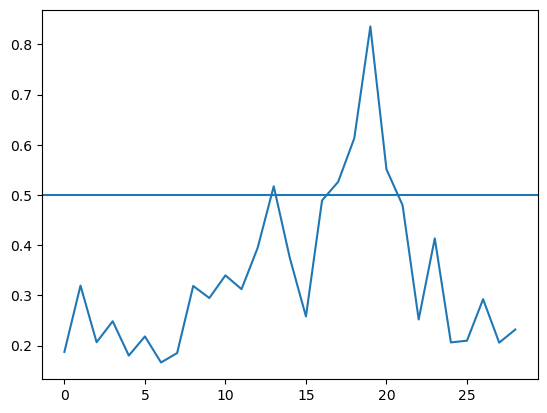

In [60]:

S_By_Ex_split_spec = split_array(cross_e_b_spectral_density)
nominator1ls = split_array(np.abs(Zxx_e ** 2))
nominator2ls = split_array(np.abs(Zxx_b ** 2))
coherences_spec = []
for i in range(len(S_By_Ex_split_spec)):
    denominator = sum(S_By_Ex_split_spec[i]) / len(S_By_Ex_split_spec[i])
    nominator = np.sqrt(sum(nominator1ls[i]) / len(nominator1ls[i])) * np.sqrt(
        sum(nominator2ls[i]) / len(nominator2ls[i]))
    print("denominator:", denominator)
    print("nominator:", nominator)
    print("denominator/nominator", denominator / nominator)
    print("coherency:", sum(np.abs(denominator / nominator)) / len(np.abs(denominator / nominator)))
    print("----------------------------------------")
    coherences_spec.append(sum(np.abs(denominator / nominator)) / len(np.abs(denominator / nominator)))

plt.figure()
plt.plot(coherences_spec)
plt.axhline(0.5)
plt.show()


